In [2]:
!nvidia-smi

Mon Apr  6 01:07:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Change directory
base = '/content/drive/My Drive/APS360 Project/v6-dataset/'

In [0]:
from __future__ import division

import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

# from utils.utils import build_targets, to_cpu, non_max_suppression

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import time
from PIL import Image

import tqdm
import pandas as pd

In [0]:
'''
Classes for the dataset 
'''

classes = {"Apple":0,
           "Bagel":1,
           "Banana":2,
           "Bread":3,
           "Broccoli":4,
           "Burrito":5,
           "Carrot":6,
           "Cheese":7,
           "Coffee":8,
           "Cookie":9,
           "Cucumber":10,
           "Egg (Food)":11,
           "French fries":12,
           "Grape":13,
           "Hamburger":14,
           "Hot dog":15,
           "Juice":16,
           "Lemon":17,
           "Lobster":18,
           "Muffin":19,
           "Orange":20,
           "Pancake":21,
           "Pasta":22,
           "Pear":23,
           "Pizza":24,
           "Potato":25,
           "Salad":26,
           "Sandwich":27,
           "Strawberry":28,
           "Taco":29,
           "Tomato":30,
           "Waffle":31}

revClasses = {val: key for (key,val) in classes.items()}

In [0]:
'''
Parse the config file

Explains what config file parameters mean
http://www.programmersought.com/article/9049233456/ 

'''


#returns a list of module objects that can be used to build the model
def parseConfig():
    with open(os.path.join(base, 'yoloArch.txt')) as file:
        arch = file.read()
        lines = arch.split('\n')
        #take out all new lines and comments
        usefulLines = [l for l in lines if l and not l[0] == '#']
        #take out whitespace before and after lines
        usefulLines = [l.rstrip().lstrip() for l in usefulLines]
        
        nnModuleList = []
        for l in usefulLines:
            #new module
            if l[0] == '[':
                newModule = {}
                newModule['module'] = l[1:-1].rstrip()
                #some lines for convolutional network don't mention batch normalization
                if newModule['module'] == 'convolutional':
                    newModule['batch_normalize'] = 0
                nnModuleList.append(newModule)
            #some property of the previous module
            else:
                vals = l.split('=')
                prop = vals[0].lstrip().rstrip()
                value = vals[1].lstrip().rstrip()
                nnModuleList[-1][prop] = value

        return nnModuleList
    

In [0]:
'''
HELPER FUNCTIONS
'''

#pads image to make it a square with 0's
def padtosquare(img):
    c, h, w = img.shape
    diff = abs(h-w)

    #equally divide padding to both sides
    padTop, padBot = diff//2, diff - diff//2
    #(0,0,padTop,padBot) = pad last dim by 0,0 on each side and past 2nd last dim by padTop,padBot on each side
    padAdd = (0,0,padTop,padBot) if h < w else (padTop,padBot,0,0)
    img2 = F.pad(img, padAdd, "constant", 0)
    return img2, padAdd

# convert box defined as center/width/height into topLeft and botRight corner points
def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def bboxIou(box1, box2):
    """
    Returns the IoU of two bounding boxes
    Boxes should be defined as top left corner, and bottom right corner
    """
    # Get the coordinates of bounding boxes 
    # x1,y1 is top left, x2, y2 is botRight
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the coordinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0)
    
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def iouAnchors(anchor, tAnchor):
    # transpose so you can get all the widths from all pictures
    tAnchor = tAnchor.t()
    intersectWidth = torch.min(anchor[0], tAnchor[0])
    intersectHeight = torch.min(anchor[1], tAnchor[1])
    intersectArea = intersectWidth * intersectHeight
    unionArea = (anchor[0] * anchor[1] + 1e-16) + (tAnchor[0] * tAnchor[1]) - intersectArea

    return intersectArea/unionArea

#builds the target values so loss can be calculated
def buildTargets(target, predBoxes, predCls, ignoreThresh, anchors):
    BoolTensor = torch.cuda.BoolTensor if predBoxes.is_cuda else torch.BoolTensor
    FloatTensor = torch.cuda.FloatTensor if predBoxes.is_cuda else torch.FloatTensor

    gridDim = predBoxes.shape[2]
    nClass = predCls.shape[-1]
    nAnchor = predBoxes.shape[1]
    nBoxes = predBoxes.shape[0]

    noobjMask = BoolTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(True)
    objMask = BoolTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(False)
    # not needed
    # classMask = FloatTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(0)
    # iouScore = FloatTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(0)
    tx = FloatTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(0)
    ty = FloatTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(0)
    tw = FloatTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(0)
    th = FloatTensor(nBoxes, nAnchor, gridDim, gridDim).fill_(0)
    tcls = FloatTensor(nBoxes, nAnchor, gridDim, gridDim, nClass).fill_(0)

    # make dimensions relative to grid dimension
    targetBoxes = target[:, 2:6] * gridDim
    bxy = targetBoxes[:, :2]
    bwh = targetBoxes[:, 2:]

    # find intersect over union of all anchors on the actual bounding box
    iou = torch.stack([iouAnchors(anchor, bwh) for anchor in anchors])
    # get intersect over union 
    iouMaxes, iouInd = iou.max(0)
    b, targetLabels = target[:, :2].long().t()

    bx, by = bxy.t()
    bw, bh = bwh.t()
    #convert into integers
    bi, bj = bxy.long().t()

    # set boxes with highest IOU to objects and set them to 0 in noobj
    objMask[b, iouInd, bj, bi] = True
    noobjMask[b, iouInd, bj, bi] = False

    #all boxes that have conf > ignoreThresh, don't count in loss calculation
    for i, anchorIOUs in enumerate(iou.t()):
        noobjMask[b[i], anchorIOUs > ignoreThresh, bj[i], bi[i]] = False

    #offsets (rearrange equations in the paper)
    tx[b, iouInd, bj, bi] = bx - bx.floor()
    ty[b, iouInd, bj, bi] = by - by.floor()
    tw[b, iouInd, bj, bi] = torch.log(bw / anchors[iouInd][:, 0] + 1e-16)
    th[b, iouInd, bj, bi] = torch.log(bh / anchors[iouInd][:, 1] + 1e-16)

    #one-hot encoding of class labels
    tcls[b, iouInd, bj, bi, targetLabels] = 1

    #bounding box confidences within targets (100% for each bounding box identified)
    tconf = objMask.float()
    return noobjMask, objMask, tx, ty, tw, th, tcls, tconf

def nonMaxSuppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections (only get useful boxes)
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_conf, class_pred)
    
    input: [nsamples, anchors*gridSize*gridSize, (bx,by,bw,bh,bconf,classPreds)]
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]

    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it (largest score to smallest) argsort sorts smallest to largest
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        
        # Perform non-maximum suppression (removes duplicate boxes)
        keep_boxes = []
        while detections.size(0):
            large_overlap = bboxIou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            # add merged bounding boxes together and add to output
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output

In [0]:
'''
Build YOLO Arch

yolov3 paper:
https://arxiv.org/pdf/1804.02767.pdf
'''

#placeholder layer for shortcut and routes
class emptyLayer(nn.Module):
    def __init__(self):
        super(emptyLayer, self).__init__()

#upsample layer
class Upsample(nn.Module):
    def __init__(self, scale_factor, mode='nearest'):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

#yolo layer
class detectLayer(nn.Module):
    def __init__(self, anchors, numClasses, imgSize, ignore_thresh, coord=4, noobj=1):
        super(detectLayer, self).__init__()
        self.anchors = anchors
        self.nAnchors = len(anchors)
        self.nClass = numClasses
        self.objScale = 2
        self.noobjScale = noobj
        self.classScale = 1
        self.dimScale = coord
        self.imgSize = imgSize
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCELoss()
        self.ignoreThresh = ignore_thresh
        self.gridSize = 0
    
    def recalcGrid(self, g, cuda=True):
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.gridSize = g
        self.cellDim = self.imgSize / g #width and height of a grid cell

        # dim = [1,1,g,g].  Offsets relative to the grid (0,1,2,etc.)
        self.xOffset = torch.arange(g).repeat(g, 1).view([1,1,g,g]).type(FloatTensor)
        self.yOffset = torch.arange(g).repeat(g, 1).t().view([1,1,g,g]).type(FloatTensor)

        #calculate scaled anchor dimensions (normalize to the grid)
        self.scaled_anchors = FloatTensor([(a_w / self.cellDim, a_h / self.cellDim) for a_w, a_h in self.anchors])

        #first coordinate value is the width of anchors
        self.wAnchor = self.scaled_anchors[:, 0:1].view([1, self.nAnchors, 1, 1])
        #second coordinate value is the height
        self.hAnchor = self.scaled_anchors[:, 1:2].view([1, self.nAnchors, 1, 1])

    #x = some dimension from the previous layer in the network
    def forward(self, x, target=None, imgSize=None):
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        
        # scale the anchors relative to new image size
        # if imgSize != self.imgSize:
        #     self.anchors = self.anchors * imgSize/self.imgSize

        self.imgSize = imgSize
        nData = x.shape[0]
        gridSize = x.shape[2]

        #5 = tx,ty,tw,th,box confidence
        data = x.view(nData, self.nAnchors, 5 + self.nClass, gridSize, gridSize)
        # make a duplicate of x that has the dimensions permuted 
        # [data, anchors, gridsize, gridsize, classes + box data]
        data = data.permute(0,1,3,4,2).contiguous()

        x = torch.sigmoid(data[..., 0]) #sigmoid on only tx
        y = torch.sigmoid(data[..., 1]) #sigmoid on only ty
        w = data[..., 2] #tw
        h = data[..., 3] #th
        # print(f'Data: {data[..., 4]}')

        boxConf = torch.sigmoid(data[..., 4]) #box_conf in [0,1]
        predCls = torch.sigmoid(data[..., 5:]) #sigmoid all the class predictions

        if self.gridSize != gridSize:
            self.recalcGrid(gridSize, x.is_cuda)

        #[..., 4] the 4 is bx,by,bw,bh
        #apply formula -> bx and by are the center of the box
        boxes = FloatTensor(data[..., :4].shape) 
        boxes[..., 0] = x + self.xOffset
        boxes[..., 1] = y + self.yOffset
        boxes[..., 2] = torch.exp(w) * self.wAnchor
        boxes[..., 3] = torch.exp(h) * self.hAnchor

        #concat all the new bounding boxes with the confidence scores
        #[nsamples, anchors*gridSize*gridSize, (bx,by,bw,bh,bconf,classPreds)]
        out = torch.cat(
            (
                boxes.view(nData, -1, 4) * self.cellDim, #scale them up based on cell size
                boxConf.view(nData, -1, 1),
                predCls.view(nData, -1, self.nClass),
            ),
            -1
        )

        if target is None:
            return out, 0
        else:
            noobjMask, objMask, tx, ty, tw, th, tcls, tconf = buildTargets(
                target, 
                boxes,
                predCls,
                self.ignoreThresh,
                self.scaled_anchors
            )
        
        #calculate losses
        lossX = self.mse(x[objMask], tx[objMask])
        lossY = self.mse(y[objMask], ty[objMask])
        lossW = self.mse(w[objMask], tw[objMask])
        lossH = self.mse(h[objMask], th[objMask])
        lossConf = self.noobjScale * self.bce(boxConf[noobjMask], tconf[noobjMask]) + \
                   self.objScale * self.bce(boxConf[objMask], tconf[objMask])
        lossCls = self.classScale * self.bce(predCls[objMask], tcls[objMask])
        # print(f'w: {w[objMask]}')
        # print(f'tw: {tw[objMask]}')
        # print(f'lossX: {lossX}')
        # print(f'lossY: {lossY}')
        # print(f'lossW: {lossW}')
        # print(f'lossH: {lossH}')
        # print(f'lossConf: {lossConf}')
        # print(f'lossCls: {lossCls}')
        totalLoss = self.dimScale * (lossX + lossY + lossW + lossH) + lossConf + lossCls

        #out in the form: [nsamples, anchors*gridSize*gridSize, (bx,by,bw,bh,bconf,classPreds)]
        return out, totalLoss

#returns a nn.ModuleList of the entire YOLO Architecture
#and the hyperparameters
def buildArch(nnModuleList):
    #get model parameters
    params = nnModuleList.pop(0)
    moduleList = nn.ModuleList([])
    #first out channel is the in channel of the first layer
    outChannels = [int(params['channels'])]

    for i,m in enumerate(nnModuleList):
        temp = nn.Sequential()

        if m['module'] == 'convolutional':
            numFilters = int(m['filters'])
            padding = (int(m['size']) - 1) // 2

            conv = nn.Conv2d(
                in_channels = outChannels[-1],
                out_channels = numFilters,
                kernel_size = int(m['size']),
                stride = int(m['stride']),
                padding = padding,
                bias = not int(m['batch_normalize'])
            )
            temp.add_module(f'conv2D_{i}', conv)

            if int(m['batch_normalize']):
                temp.add_module(f'batchNorm_{i}', nn.BatchNorm2d(int(m['filters'])))

            temp.add_module(f'leaky_{i}', nn.LeakyReLU())

        elif m['module'] == 'shortcut':
            prevLayer = int(m['from'])
            numFilters = int(outChannels[1:][prevLayer]) #ignore the inchannel
            temp.add_module(f'shortcut_{i}', emptyLayer())

        elif m['module'] == 'route':
            prevLayers = m['layers'].split(',')
            numFilters = sum([outChannels[1:][int(i)] for i in prevLayers]) #ignore the inchannel
            temp.add_module(f'route_{i}', emptyLayer())
        
        elif m['module'] == 'upsample':
            upsample = Upsample(scale_factor=int(m['stride']), mode='nearest')
            temp.add_module(f'upsample_{i}', upsample)

        elif m['module'] == 'yolo':
            anchor_ind = m['mask'].split(',')
            anchor_ind = [int(i) for i in anchor_ind]
            anchors = m['anchors'].split(',')
            # only get anchors that are indicated by the mask
            anchors = [(int(anchors[i]), int(anchors[i+1])) for i in range(0, len(anchors), 2) if i//2 in anchor_ind]
            # anchors, classes, image height, ignore threshold
            yolo = detectLayer(anchors, int(m['classes']), int(params['height']), float(m['ignore_thresh']))
            temp.add_module(f'detectLayer_{i}', yolo)

        outChannels.append(numFilters)
        moduleList.append(temp)

    return params, moduleList

In [0]:
'''
Actual Model - YOLO
'''

class YOLO(nn.Module):
    def __init__(self, imgSize = 416):
        super(YOLO, self).__init__()
        self.modList = parseConfig()
        self.hyperparams, self.layers = buildArch(self.modList)
        self.imgSize = imgSize
    
    def forward(self, x, target=None):
        imgDim = x.shape[2]
        loss = 0
        outputs = [x]
        yoloOutputs = []

        for i, (mDetails, layer) in enumerate(zip(self.modList, self.layers)):
            if mDetails['module'] == 'convolutional' or mDetails['module'] == 'upsample':
                out = layer(outputs[-1])

            elif mDetails['module'] == 'shortcut':
                prevLayer = int(mDetails['from'])
                out = outputs[prevLayer] + outputs[-1]

            elif mDetails['module'] == 'route':
                prevLayers = mDetails['layers'].split(',')
                out = torch.cat([outputs[int(layer_i)] for layer_i in prevLayers], 1)
            
            elif mDetails['module'] == 'yolo':
                # layer[0] to get the yolo layer in the nn.sequential
                out, tempLoss = layer[0](outputs[-1], target, imgDim)
                loss += tempLoss   
                yoloOutputs.append(out)

            outputs.append(out)

        # out = [1, all yolo outputs, 37 (32 classes + 5 box data)]
        yoloOutputs = torch.cat(yoloOutputs, 1).detach().cpu()
        return yoloOutputs if target is None else (yoloOutputs, loss)


In [0]:
'''
TRAIN
'''
#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def resizeImage(img, size):
    return F.interpolate(img.unsqueeze(0), size, mode='nearest').squeeze(0)

def dataloader(filePath='yolo-train-id.csv', batch_size=8, imgSize=416, normalize=False):
    # Load default width
    widthScale = 416
    
    # Load csv and shuffle
    headers = pd.read_csv(os.path.join(base, filePath))
    headers = headers.sample(frac=1)
    transform = transforms.ToTensor()
    if normalize:
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # Make tensor of images, (labels and bbox)
    for i in range(0, len(headers.filePath), batch_size):
        imgs, label = [], []
        
        for j in range(batch_size):
            # Old image
            if i+j >= len(headers.filePath):
                break

            imgOG = Image.open(headers.filePath[i+j]).convert('RGB')
            shapeOG = imgOG.size[:2]
            #scale by this much to get one dimension to be 416
            #height > width
            if shapeOG[1] > shapeOG[0]:
                aspectRatio = shapeOG[0] / shapeOG[1]
                newWidth = widthScale * aspectRatio
                newDim = (int(round(newWidth)), int(round(widthScale)))
            else:
                aspectRatio = shapeOG[1] / shapeOG[0]
                newHeight = widthScale * aspectRatio
                newDim = (int(round(widthScale)), int(round(newHeight)))
            # display(imgOG)

            # New image
            img = imgOG.resize(newDim, Image.ANTIALIAS)
            # display(img)
            img = transform(img)
            #make image a square

            #tensor becomes channels, numRows, numCols
            # numRow = height, numCols = width before pad
            c, h, w = img.shape

            img, pad = padtosquare(img)
            _, padH, padW = img.shape


            imgs.append(img)

            xCent = headers.XCenter[i+j]
            yCent = headers.YCenter[i+j]
            bWidth = headers.Width[i+j]
            bHeight = headers.Height[i+j]

            # move the bounding box according to new dimensions
            x1 = w * (xCent - bWidth / 2) + pad[0]
            x2 = w * (xCent + bWidth / 2) + pad[1]
            y1 = h * (yCent - bHeight / 2) + pad[2]
            y2 = h * (yCent + bHeight / 2) + pad[3]

            #get new center and width/height
            xCent = (x2 + x1) / 2 / padW
            yCent = (y2 + y1) / 2 / padH
            bWidth *= w / padW
            bHeight *= h / padH

            # Add box to labels
            box = torch.tensor([j,
                                classes[headers.Class_Description[i+j]],
                                xCent, 
                                yCent, 
                                bWidth, 
                                bHeight])

            label.append(box)
        
        imgs = torch.stack(imgs)
        label = torch.stack(label)
        yield imgs, label

def trainYOLO(model, epochs, batchSize=8, checkpointPath=None):
    trainLosses, valLosses = [], []
    trainAcc, valAcc = [], []
    lr = float(model.hyperparams['learning_rate'])
    weightDecay = float(model.hyperparams['decay'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weightDecay)

    if checkpointPath is not None:
        vals = torch.load(os.path.join(base, checkpointPath))
        model.load_state_dict(vals['model_state_dict'])
        optimizer.load_state_dict(vals['optimizer_state_dict'])
        trainLosses = vals['saved_train_loss']
        valLosses = vals['saved_val_loss']
        trainAcc = vals['train_acc']
        valAcc = vals['val_acc']

    checkpointNum = 0
    start = time.time()

    for epoch in range(epochs):
        model.train()
        trainData = dataloader(batch_size=batch_size)

        for batchNum, (imgs, labels) in tqdm.tqdm(enumerate(trainData)):

            imgs = imgs.to(device)
            labels = labels.to(device)
            # print(f'imgs: {imgs}')
            outputs, loss = model(imgs, labels)
            loss.backward()


            # accumulate gradients before changing weights
            if batchNum % 2:
                optimizer.step()
                optimizer.zero_grad()


            if batchNum % 1000 == 0:
                #checkpoint model training every 1000 batches
                torch.save({
                    'checkpoint_num': checkpointNum,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'saved_train_loss': trainLosses,
                    'saved_val_loss':valLosses,
                    'train_acc':trainAcc,
                    'val_acc':valAcc
                }, os.path.join(base, f'yolo-checkpoints/yolo_epoch{epoch}_lr{lr}_checkpoint{checkpointNum}.pth'))

                checkpointNum += 1
            
            end = time.time()
            trainLosses.append(float(loss.item())/batchSize)
            print('\n-----------------------------------------')
            print(f'Epoch: {epoch}')
            print(f'TrainLoss: {trainLosses[-1]}')
            print(f'Time Elapsed: {end-start}')
            print('-----------------------------------------')

In [0]:
'''
TEST MODEL
'''

def getAccLoss(model, dataLoader, imgSize=416, confThresh=0.5, nmsThresh=0.4):
    overlapRatio = 0.4
    loss = 0
    correct = 0
    total = 0
    for batchNum, (imgs, labels) in enumerate(dataLoader, 1):
        imgs = imgs.to(device)
        labels = labels.to(device) 

        with torch.no_grad():
            outputs, lossTemp = model(imgs, labels)
            outputs = nonMaxSuppression(outputs, confThresh, nmsThresh)

        labels = labels.detach().cpu()
        #convert to xyxy coordinates
        labels[:, 2:] = xywh2xyxy(labels[:, 2:])

        loss += lossTemp.item()
        for i, boxes in enumerate(outputs):
            if boxes is None:
                continue
            mask = boxes[:, -1] == labels[i, 1]
            boxCLabel = boxes[mask]
            labelBox = labels[i, 2:] * imgSize
            overlap = bboxIou(labelBox.unsqueeze(0), boxCLabel[:, :4]) > overlapRatio
            if overlap.float().sum() != 0:
                correct += 1
        total += imgs.shape[0]

        print(f'acc: {float(correct)/total}')
        print(f'loss: {float(loss)/batchNum}')

    return float(loss)/batchNum, float(correct)/total

def testYOLO(model, checkpointPath, testFilePath='test_image_folder', batchSize=16, confThresh=0.5, nmsThresh=0.4, display=True):
    checkpointData = torch.load(os.path.join(base, checkpointPath))
    model.load_state_dict(checkpointData['model_state_dict'])
    if display:
        return testDisplay(model, testFilePath, confThresh, nmsThresh)
    else:
        testData = dataloader(filePath = testFilePath, batch_size=batchSize)
        loss, acc = getAccLoss(model, testData, confThresh=confThresh, nmsThresh=nmsThresh)
        return loss, acc

def testDisplay(model, filePath='test_image_folder', confThresh=0.5, nmsThresh=0.4, imgSize=416):
    model.eval()
    test_data = torchvision.datasets.ImageFolder(os.path.join(base, filePath),
                                             loader=plt.imread,
                                             transform=transforms.ToTensor())
    img_show = []
    for i in range(len(test_data)):
        img_show.append(plt.imread(test_data.imgs[i][0]))
    
    widthScale = imgSize
    outputs = []
    wh = []
    for img_i, img in enumerate(test_data.imgs):
        imgOG = Image.open(img[0]).convert('RGB')
        wOG, hOG = imgOG.size[:2]
        shapeOG = imgOG.size[:2]
        #scale by this much to get one dimension to be 416
        #height > width
        if shapeOG[1] > shapeOG[0]:
            aspectRatio = shapeOG[0] / shapeOG[1]
            newWidth = widthScale * aspectRatio
            newDim = (int(round(newWidth)), int(round(widthScale)))
        else:
            aspectRatio = shapeOG[1] / shapeOG[0]
            newHeight = widthScale * aspectRatio
            newDim = (int(round(widthScale)), int(round(newHeight)))
        # display(imgOG)

        # New image
        img = imgOG.resize(newDim, Image.ANTIALIAS)
        img = transforms.ToTensor()(img)
        # print(img)
        img, _ = padtosquare(img)
        img = img.to(device)

        with torch.no_grad():
            output = model(img.unsqueeze(0))
            # print(output.shape)
            output = nonMaxSuppression(output, confThresh, nmsThresh)
            # print(output[0].shape)
            outputs.append(output)

        wh.append((wOG,hOG))

    return img_show, outputs, wh

In [0]:
model = YOLO().to(device)
img_show, outputs, wh = testYOLO(model, checkpointPath='yolo-checkpoints/yolo_epoch3_lr0.001_checkpoint4.pth', testFilePath='rcnn-test-images', confThresh=0.95, nmsThresh=0.4)

311, 523
newDim: (416, 247)
268, 595
newDim: (416, 187)
429, 647
newDim: (416, 276)
236, 441
newDim: (416, 223)


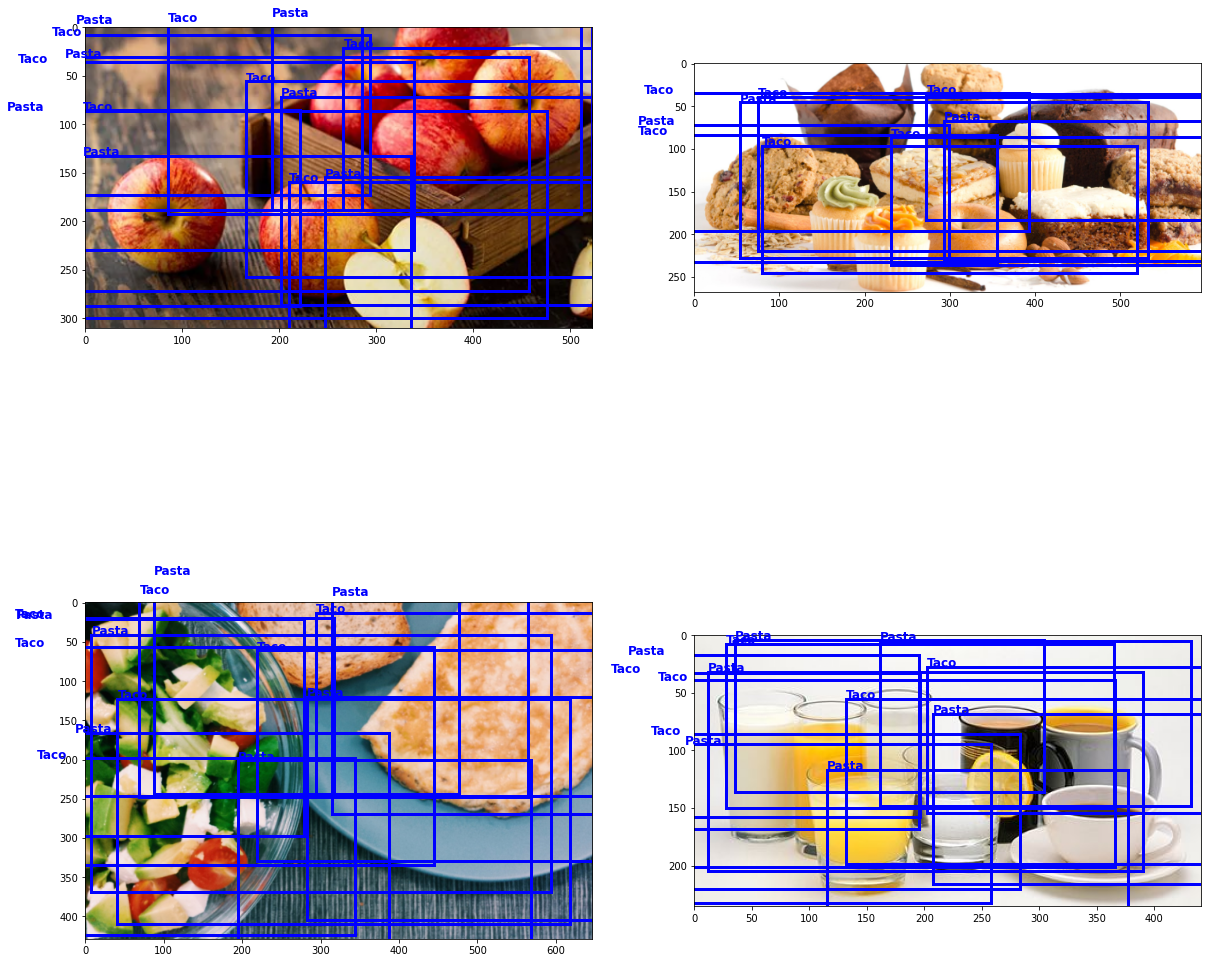

In [15]:
plotDimX = 2
plotDimY = 2
f, ax = plt.subplots(plotDimY,plotDimX, figsize=(20,20))
start = 0
for i in range(start, len(outputs)):
    if i == start + 4:
        break
    j = i - start
    # plot the pictures and its bounding boxes (should be referring to the original path)
    # ax[i//plotDim][i%plotDim].cla()
    # print(img_show[i].shape)
    ax[j//plotDimY][j%plotDimX].imshow(img_show[i])
    h, w, _ = img_show[i].shape
    print(f'{h}, {w}')
    if h > w:
        aspectRatio = w / h
        newWidth = 416 * aspectRatio
        newDim = (int(round(newWidth)), int(round(416)))
    else:
        aspectRatio = h / w
        newHeight = 416 * aspectRatio
        newDim = (int(round(416)), int(round(newHeight)))
    print(f'newDim: {newDim}')
    if outputs[i][0] is None:
        continue
    for box in range(outputs[i][0].shape[0]):

        # scale the boxes based on the original image size
        x1 = outputs[i][0][box][0] * w/416
        y1 = outputs[i][0][box][1] * h/416
        x2 = outputs[i][0][box][2] * w/416
        y2 = outputs[i][0][box][3] * h/416

        ax[j//plotDimY][j%plotDimX].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='b', linewidth=3))
        ax[j//plotDimY][j%plotDimX].text(x1, y1, revClasses[int(outputs[i][0][box][-1])], color='blue', fontsize=12, weight='bold')

    
plt.show()

In [0]:
model = YOLO().to(device)
loss, acc = testYOLO(model, checkpointPath='yolo-checkpoints/yolo_epoch2_lr0.001_checkpoint4.pth', testFilePath='yolo-train-id.csv', confThresh=0.2, nmsThresh=0.4, display=False)
print(loss)
print(acc)

acc: 0.0
loss: 36.203861236572266
acc: 0.03125
loss: 33.33726787567139
acc: 0.0625
loss: 33.38515663146973
acc: 0.0625
loss: 35.54218244552612
acc: 0.05
loss: 34.61506538391113


KeyboardInterrupt: ignored